# Tech Note Demo

This notebook reproduces the figures from the [mzapy tech note](link_to_tech_note), and serves as a demonstration of the package's functionality. The data file used in this demo can be found [here](link_to_demo_mza_file). 

_To download and run this demo notebook, first download the data file from the link above, then at the top of this page click "View page source", then right-click and save as "demo.ipynb" on your machine._

## Imports

In [1]:
from matplotlib import pyplot as plt, rcParams

from mzapy import MZA
from mzapy.isotopes import MolecularFormula, monoiso_mass, predict_m_m1_m2
from mzapy.peaks import find_peaks_1d_gauss, find_peaks_1d_localmax
from mzapy.view import plot_chrom, plot_spectrum, plot_atd, add_peaks_to_plot

## Setup

In [2]:
# increase the font size to make rendered plots more legible
rcParams['font.size'] = 10

# calculate some info for PC(18:0/18:1) [M+H]+ (C44H87NO8P)
pc_formula = MolecularFormula(C=44, H=87, N=1, O=8, P=1)
pc_mz = monoiso_mass(pc_formula)
pc_iso_masses, pc_iso_abun = predict_m_m1_m2(pc_formula)

# load the MZA file
mza = MZA('demo_data.mza', mza_version='old')


## Extract and View XIC

TIC and XIC (no fitting)


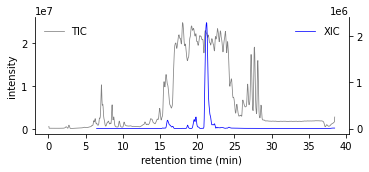

XIC with gaussian fit


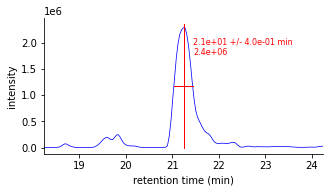

In [3]:
# extract the chromatogram for the monoiso m/z +/- 0.02
mz_min, mz_max = pc_mz - 0.02, pc_mz + 0.02
xic_rt, xic_i = mza.collect_xic_arrays_by_mz(mz_min, mz_max)

# plot TIC and XIC, without fit
print('TIC and XIC (no fitting)')
ax = plot_chrom(*mza.collect_xic_arrays_by_mz(mza.min_mz, mza.max_mz), 
                c='grey', label='TIC', figsize=(5.5, 2.5))
ax2 = ax.twinx()
for d in ['top', 'left', 'bottom']:
    ax2.spines[d].set_visible(False)
ax.legend(frameon=False, loc='upper left')
plot_chrom(xic_rt, xic_i, 
           ax=ax2, figname='show', label='XIC')

# fit XIC to get the obs. retention time, plot fitted RT for two peaks
pk_means, pk_heights, pk_widths = find_peaks_1d_gauss(xic_rt, xic_i, 
                                                      0.05, 1e3, 0.05, 
                                                      2, 1, True)
# only look for the most intense peak
pk_mean, pk_height, pk_width = pk_means[0], pk_heights[0], pk_widths[0]      

# plot the region around the fitted chromatographic peak
print('XIC with gaussian fit')
ax = plot_chrom(xic_rt, xic_i, 
                rt_range=[pk_mean - 3, pk_mean + 3], figsize=(5, 2.5))

# annotate with the fitted peak
add_peaks_to_plot(ax, pk_means, pk_heights, pk_widths, 
                  add_text_lbl=True, x_units='min', fontsize=8)

# show the plot and close
plt.show()
plt.close()


## Extract and View MS1 Spectra

MS1 spectrum (full m/z range)


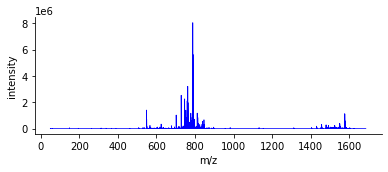

MS1 spectrum (M - 1.5 to M + 3.5)


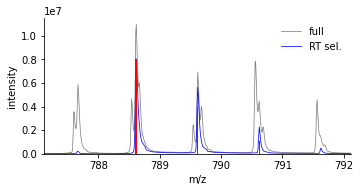

In [4]:
# extract MS1 spectrum from fitted RT +/- FWHM (full m/z range)
rt_min, rt_max = pk_mean - pk_width, pk_mean + pk_width
ms1_mz, ms1_i = mza.collect_ms1_arrays_by_rt(rt_min, rt_max)

# fit the region right around the monoisotopic mass to get the peak height of the monoisotopic peak
ms1_pk_height = find_peaks_1d_localmax(
    *mza.collect_ms1_arrays_by_rt(rt_min, rt_max, 
                                  mz_bounds=(pc_mz - 0.5, pc_mz + 0.5)), 
    0.05, 1e3, 0.01, 1, 0.2)[1][0]

# plot MS1 spectrum, full m/z range
print('MS1 spectrum (full m/z range)')
plot_spectrum(ms1_mz, ms1_i, figname='show', figsize=(5.5, 2.5))

# plot MS1 spectrum, M - 1.5 to M + 3.5
# annotate with bars corresponding to theoretical isotope distribution
print('MS1 spectrum (M - 1.5 to M + 3.5)')
ax = plot_spectrum(*mza.collect_ms1_arrays_by_rt(mza.min_rt, mza.max_rt, 
                                                 mz_bounds=(pc_mz - 1.5, pc_mz + 3.5)), 
                   mz_range=(pc_mz - 1.5, pc_mz + 3.5), c='grey', label='full', figsize=(5.5, 2.5))
plot_spectrum(ms1_mz, ms1_i, 
              mz_range=(pc_mz - 1.5, pc_mz + 3.5), ax=ax, label='RT sel.')
ax.bar(pc_iso_masses, [_ * ms1_pk_height for _ in pc_iso_abun], 
       width=0.025, color='r', zorder=2)
ax.legend(frameon=False)

# show the plot and close
plt.show()
plt.close()


## Extract and View ATD

ATD with and without RT selection


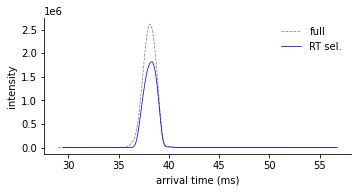

ATD with gaussian fit


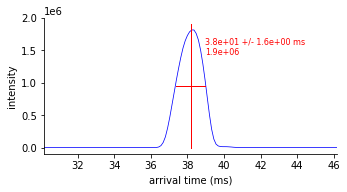

In [5]:
# extract RT and m/z selected ATD
atd_dt, atd_i = mza.collect_atd_arrays_by_rt_mz(mz_min, mz_max, rt_min, rt_max)

# It takes a very long time to get the non-RT-selected ATD, so don't run this every time
# plot ATD
ax = plot_atd(*mza.collect_atd_arrays_by_rt_mz(mz_min, mz_max, mza.min_rt, mza.max_rt),
              c='grey', ls='--', label='full', figsize=(5.5, 2.5))
plot_atd(atd_dt, atd_i, label='RT sel.', ax=ax)
ax.legend(frameon=False)

# show the plot and close
print('ATD with and without RT selection')
plt.show()
plt.close()

# fit ATD to get observed drift time
atd_means, atd_heights, atd_widths = find_peaks_1d_gauss(atd_dt, atd_i, 
                                                         0.05, 1e3, 1, 
                                                         20, 1, True)
atd_mean, atd_height, atd_width = atd_means[0], atd_heights[0], atd_widths[0]

# plot the ATD with fit
ax = plot_atd(atd_dt, atd_i, 
              dt_range=[atd_mean - 8, atd_mean + 8], figsize=(5.25, 2.5))

# annotate with the fitted peak
add_peaks_to_plot(ax, atd_means, atd_heights, atd_widths, 
                  add_text_lbl=True, x_units='ms', fontsize=8)

# show the plot and close
print('ATD with gaussian fit')
plt.show()
plt.close()


## Cleanup

In [6]:
# close the MZA interface
mza.close()
